In [ ]:
# Part of the code is based on: https://www.geeksforgeeks.org/sarsa-reinforcement-learning/

In [1]:
import gym
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from hyperopt import fmin, tpe, hp

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
def initialize_q_values(env):
    nA = env.action_space.n
    return defaultdict(lambda: np.zeros(nA))


def get_action(state, q_values, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_values[state])
    return action


def update_q_values(curr_state, curr_action, reward, next_state, next_action, q_values, lr, gamma):
    td_target = reward + gamma * q_values[next_state][next_action]
    td_error = td_target - q_values[curr_state][curr_action]
    q_values[curr_state][curr_action] += lr * td_error


In [4]:
def train_sarsa(env, n_episodes, lr, epsilon, gamma):
    q_values = initialize_q_values(env)
    epsilon_decay = epsilon / n_episodes
    stats = []
    win = 0
    loss = 0

    for episode in range(n_episodes):
        dict_state = env.reset()
        state = dict_state[0]
        done = False

        while not done:
            action = get_action(state, q_values, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            next_action = get_action(next_state, q_values, epsilon)
            update_q_values(state, action, reward, next_state, next_action, q_values, lr, gamma)
            state = next_state
        
        if reward >= 1.0:
            win += 1
        elif reward == -1.0:
            loss += 1
            
        winrates = (win/(episode + 1))*100
            
        stats.append([episode, winrates])
            

    winrate = win / n_episodes
    lossrate = loss / n_episodes

        
    return q_values, winrate



In [5]:
space = {
    'lr': hp.uniform('lr', 0, 1),
    'epsilon': hp.uniform('epsilon', 0, 1),
    'gamma': hp.uniform('gamma', 0, 1)
}
def objective(params):
    lr = params['lr']
    epsilon = params['epsilon']
    gamma = params['gamma']
    n_episodes = 100_000

    q_values, winrate = train_sarsa(env, n_episodes, lr, epsilon, gamma)
    return -winrate #need to minimize the return

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print("Best hyperparameters:", best)


  0%|          | 0/100 [00:04<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
# Part of the code for plotting the policy was used from: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

In [6]:
def create_grids(agent, use_ace):
   
    usable_ace = use_ace
    V = defaultdict(float)
    policy = defaultdict(int)

    for obs, action_values in agent.items():
        V[obs] = np.max(action_values)
        policy[obs] = np.argmax(action_values)

    X, Y = np.meshgrid(
        np.arange(12, 22),  
        np.arange(1, 11))

    Z = np.apply_along_axis(lambda obs: V[(obs[0], obs[1], usable_ace)], axis=2, arr=np.dstack([X, Y]))
    value_grid = X, Y, Z

    policy_grid = np.apply_along_axis(lambda obs: policy[(obs[0], obs[1], usable_ace)],
                                      axis=2, arr=np.dstack([X, Y]))
    
    return policy_grid


def create_plots(policy_grid, titles):
    custom_cmap = LinearSegmentedColormap.from_list('custom', ["lightcoral", "white", "lightgreen"], N=256)

    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap=custom_cmap, cbar=False)
    heatmap.set_xlabel("Player sum")
    heatmap.set_ylabel("Dealer card")
    heatmap.set_xticklabels(range(12, 22))
    heatmap.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)

    legend_elements = [Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
                       Patch(facecolor='lightcoral', edgecolor='black', label='Stick')]
    heatmap.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
#     plt.savefig("MC " + titles)
    plt.show()

In [7]:
episodes = 1_000_000
lr = 0.07146068584965157
epsilon = 0.05212331363684942
gamma = 0.029098902913149344

q_values, winrate = train_sarsa(env, episodes, lr, epsilon, gamma)

In [8]:
def test_policy(env, q_values, num_episodes):
    wins = 0
    losses = 0
    total_reward = 0  
    stats = []
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0  
        
        while not done:
            action = get_best_action(state, q_values)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward  
            state = next_state
            
        if reward >= 1.0:
            wins += 1
        elif reward == -1.0:
            losses += 1
        
        win_rate = (wins / (episode + 1)) * 100
        stats.append([episode, win_rate])
        
        total_reward += episode_reward 
    
    win_rate = wins / num_episodes
    average_reward = total_reward / num_episodes 
    
    print(f"Tested on {num_episodes} episodes")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Loss rate: {(losses / num_episodes) * 100:.2f}%")
    print(f"Average reward: {average_reward:.2f}")

#     df = pd.DataFrame(stats, columns=['Episode', 'WinRate'])
#     df.to_csv("SARSA.csv", index=False)

In [9]:
def get_best_action(state, q_values):
    return np.argmax(q_values[state])

In [10]:
num_episodes = 1_000_000
win_rate = test_policy(env, q_values, num_episodes)

Tested on 1000000 episodes
Win rate: 42.50%
Loss rate: 48.15%
Average reward: -0.06


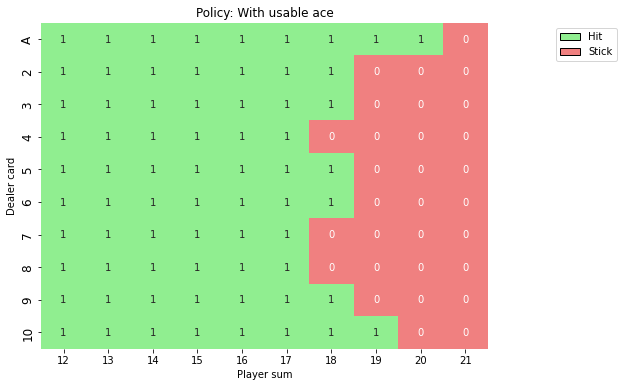

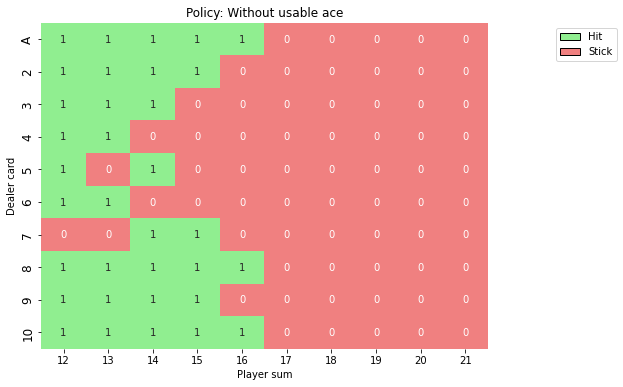

In [11]:
use_ace = True
value_grid, policy_grid = create_grids(q_values, use_ace)
create_plots(policy_grid, titles="With usable ace")

use_ace = False
value_grid, policy_grid = create_grids(q_values, use_ace)
create_plots(policy_grid, titles="Without usable ace")


In [13]:
def run_iterations(env, episodes, q_values, num_iterations):
    total_win = 0
    win_list = []

    for _ in range(num_iterations):
        win_rate = test_policy(env, q_values, episodes)
        total_win += win_rate[0]
        win_list.append(win_rate[0])
        print("{} of {} actions completed...".format(_ + 1, num_iterations))

    avg_win_rate = total_win / num_iterations

    print('Average win rate: {:.2f}%'.format(avg_win_rate * 100))
    print(win_list)

episodes = 1_000_000
num_itterations = 10

run_iterations(env, episodes, q_values, num_itterations)

Tested on 1000 episodes
Win rate: 39.60%
Loss rate: 53.90%
Average reward: -0.14
1 of 10 actions completed...
Tested on 1000 episodes
Win rate: 41.60%
Loss rate: 50.90%
Average reward: -0.09
2 of 10 actions completed...
Tested on 1000 episodes
Win rate: 39.20%
Loss rate: 52.10%
Average reward: -0.13
3 of 10 actions completed...
Tested on 1000 episodes
Win rate: 40.80%
Loss rate: 51.20%
Average reward: -0.10
4 of 10 actions completed...
Tested on 1000 episodes
Win rate: 40.60%
Loss rate: 53.70%
Average reward: -0.13
5 of 10 actions completed...
Tested on 1000 episodes
Win rate: 39.20%
Loss rate: 53.30%
Average reward: -0.14
6 of 10 actions completed...
Tested on 1000 episodes
Win rate: 44.70%
Loss rate: 49.50%
Average reward: -0.05
7 of 10 actions completed...
Tested on 1000 episodes
Win rate: 42.00%
Loss rate: 51.60%
Average reward: -0.10
8 of 10 actions completed...
Tested on 1000 episodes
Win rate: 41.10%
Loss rate: 53.00%
Average reward: -0.12
9 of 10 actions completed...
Tested on 